In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.widgets import Button
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class Fanorona:
    def __init__(self):
        self.current_player = "Blancs"
        self.board = [[None for _ in range(3)] for _ in range(3)]
        self.pieces_placed = {"Blancs": 0, "Noir": 0}
        self.selected_piece = None

        # Initialiser matplotlib
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.ax.set_facecolor("#F5DEB3")  # Fond couleur bois
        self.ax.set_xlim(0, 300)
        self.ax.set_ylim(0, 300)
        self.ax.set_aspect('equal')
        self.ax.axis('off')  # Cacher les axes

        # Dessiner le plateau
        self.draw_board()

        # Gérer les clics sur le plateau
        self.fig.canvas.mpl_connect('button_press_event', self.handle_click)

        # Bouton de réinitialisation
        ax_reset = plt.axes([0.4, 0.05, 0.2, 0.075])  # Position du bouton
        self.reset_button = Button(ax_reset, 'Rejouer', color="#8B4513", hovercolor="#A0522D")
        self.reset_button.on_clicked(self.reset_game)

        # Afficher le tour actuel
        self.info_label = self.ax.text(150, 320, f"Tour des : {self.current_player}", 
                                       fontsize=14, ha='center', va='center', color="black")

        plt.show()

    def draw_board(self):
        # Dessiner les lignes du plateau
        for i in range(3):
            self.ax.plot([50, 250], [50 + i * 100, 50 + i * 100], color="brown", linewidth=2)  # Horizontales
            self.ax.plot([50 + i * 100, 50 + i * 100], [50, 250], color="brown", linewidth=2)  # Verticales
        self.ax.plot([50, 250], [50, 250], color="brown", linewidth=2)  # Diagonale principale
        self.ax.plot([250, 50], [50, 250], color="brown", linewidth=2)  # Diagonale secondaire

        # Dessiner les intersections
        self.intersections = []
        for row in range(3):
            for col in range(3):
                x, y = 50 + col * 100, 50 + row * 100
                self.intersections.append((x, y))
                self.ax.add_patch(Circle((x, y), 10, color="brown"))  # Taille ajustée

    def handle_click(self, event):
        if event.inaxes != self.ax:
            return  # Ignorer les clics en dehors du plateau

        x, y = event.xdata, event.ydata

        # Trouver l'intersection la plus proche
        for idx, (ix, iy) in enumerate(self.intersections):
            if abs(x - ix) <= 20 and abs(y - iy) <= 20:
                row, col = divmod(idx, 3)
                if self.board[row][col] == self.current_player:
                    self.select_piece(row, col)
                elif self.selected_piece:
                    self.move_piece(row, col, ix, iy)
                elif self.board[row][col] is None and self.pieces_placed[self.current_player] < 3:
                    self.place_piece(row, col, ix, iy)
                break

    def place_piece(self, row, col, x, y):
        # Placer le pion
        color = "white" if self.current_player == "Blancs" else "black"
        self.ax.add_patch(Circle((x, y), 15, color=color))
        self.board[row][col] = self.current_player
        self.pieces_placed[self.current_player] += 1

        if self.check_winner(row, col):
            print(f"FIN DE PARTIE: Les {self.current_player} gagnent !")
            self.reset_game()
            return

        # Changer de joueur
        self.current_player = "Noir" if self.current_player == "Blancs" else "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

    def select_piece(self, row, col):
        # Réinitialiser la bordure de l'ancien pion sélectionné
        if self.selected_piece:
            prev_row, prev_col = self.selected_piece
            for patch in self.ax.patches:
                if isinstance(patch, Circle) and patch.get_center() == (50 + prev_col * 100, 50 + prev_row * 100):
                    patch.set_edgecolor("black")
                    patch.set_linewidth(1)

        # Sélectionner le nouveau pion
        self.selected_piece = (row, col)
        for patch in self.ax.patches:
            if isinstance(patch, Circle) and patch.get_center() == (50 + col * 100, 50 + row * 100):
                patch.set_edgecolor("red")
                patch.set_linewidth(2)
                break

        self.info_label.set_text(f"{self.current_player}: Déplacez vers une case vide")
        self.fig.canvas.draw()

    def move_piece(self, row, col, x, y):
        if self.board[row][col] is not None:
            print("Mouvement impossible: La case est déjà occupée!")
            return

        prev_row, prev_col = self.selected_piece

        if not self.is_valid_move(prev_row, prev_col, row, col):
            print("Mouvement impossible: Essayez autre chose")
            return

        # Déplacer le pion
        self.board[prev_row][prev_col] = None
        self.board[row][col] = self.current_player

        # Effacer l'ancienne position
        for patch in self.ax.patches:
            if isinstance(patch, Circle) and patch.get_center() == (50 + prev_col * 100, 50 + prev_row * 100):
                patch.remove()
                break

        # Dessiner la nouvelle position
        color = "white" if self.current_player == "Blancs" else "black"
        self.ax.add_patch(Circle((x, y), 15, color=color))

        self.selected_piece = None

        if self.check_winner(row, col):
            print(f"FIN DE PARTIE: Les {self.current_player} gagnent !")
            self.reset_game()
            return

        # Changer de joueur
        self.current_player = "Noir" if self.current_player == "Blancs" else "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

    def is_valid_move(self, prev_row, prev_col, new_row, new_col):
        # Définir les déplacements valides en suivant les lignes du plateau
        valid_moves = {
            (0, 0): [(0, 1), (1, 0), (1, 1)],
            (0, 1): [(0, 0), (0, 2), (1, 1)],
            (0, 2): [(0, 1), (1, 1), (1, 2)],
            (1, 0): [(0, 0), (1, 1), (2, 0)],
            (1, 1): [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)],
            (1, 2): [(0, 2), (1, 1), (2, 2)],
            (2, 0): [(1, 0), (1, 1), (2, 1)],
            (2, 1): [(2, 0), (1, 1), (2, 2)],
            (2, 2): [(1, 1), (1, 2), (2, 1)]
        }

        return (new_row, new_col) in valid_moves.get((prev_row, prev_col), [])

    def check_winner(self, row, col):
        # Vérifier les lignes, colonnes et diagonales pour une victoire
        # Ligne
        if all(self.board[row][c] == self.current_player for c in range(3)):
            return True
        # Colonne
        if all(self.board[r][col] == self.current_player for r in range(3)):
            return True
        # Diagonales
        if row == col and all(self.board[i][i] == self.current_player for i in range(3)):
            return True
        if row + col == 2 and all(self.board[i][2 - i] == self.current_player for i in range(3)):
            return True

        return False

    def reset_game(self, event=None):
        self.board = [[None for _ in range(3)] for _ in range(3)]
        self.pieces_placed = {"Blancs": 0, "Noir": 0}
        self.selected_piece = None
        self.ax.clear()
        self.draw_board()
        self.current_player = "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

# Génération des données et entraînement des modèles (identique à avant)
def generate_data(self, num_games=1000):
        winning_configs = []
        losing_configs = []

        for _ in range(num_games):
            self.reset_game()
            winner = self.simulate_game()

            if winner == "Blancs":
                winning_configs.append([row[:] for row in self.board])
            elif winner == "Noir":
                losing_configs.append([row[:] for row in self.board])

            if len(winning_configs) >= 500 and len(losing_configs) >= 500:
                break

        return winning_configs, losing_configs
    
# winning_configs, losing_configs = Fanorona().generate_data()
# X, y = prepare_data(winning_configs, losing_configs)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

print(f"Accuracy de la régression logistique: {accuracy_score(y_test, y_pred_logistic)}")
print(f"Accuracy de la forêt aléatoire: {accuracy_score(y_test, y_pred_rf)}")

print("Rapport de classification pour la régression logistique:")
print(classification_report(y_test, y_pred_logistic))

print("Matrice de confusion pour la régression logistique:")
print(confusion_matrix(y_test, y_pred_logistic))

print("Rapport de classification pour la forêt aléatoire:")
print(classification_report(y_test, y_pred_rf))

print("Matrice de confusion pour la forêt aléatoire:")
print(confusion_matrix(y_test, y_pred_rf))




Accuracy de la régression logistique: 0.625
Accuracy de la forêt aléatoire: 0.945
Rapport de classification pour la régression logistique:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       104
           1       0.60      0.65      0.62        96

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.63       200

Matrice de confusion pour la régression logistique:
[[63 41]
 [34 62]]
Rapport de classification pour la forêt aléatoire:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       104
           1       0.95      0.94      0.94        96

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

Matrice de confusion pour la forêt aléatoire:
[[99  5]
 [ 6 90]]


Accuracy de la régression logistique: 0.625
Accuracy de la forêt aléatoire: 0.95
Rapport de classification pour la régression logistique:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       104
           1       0.60      0.65      0.62        96

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.63       200

Matrice de confusion pour la régression logistique:
[[63 41]
 [34 62]]
Rapport de classification pour la forêt aléatoire:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       104
           1       0.94      0.96      0.95        96

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

Matrice de confusion pour la forêt aléatoire:
[[98  6]
 [ 4 92]]


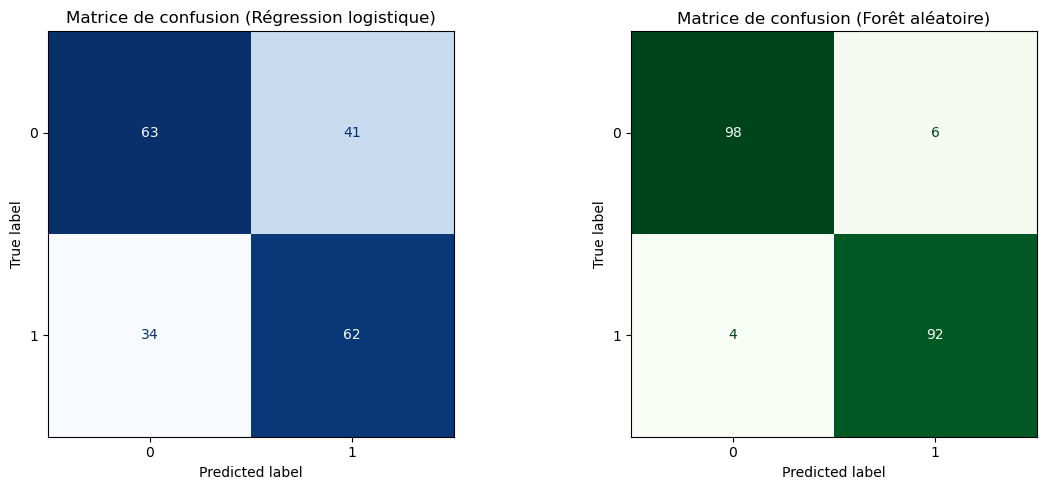

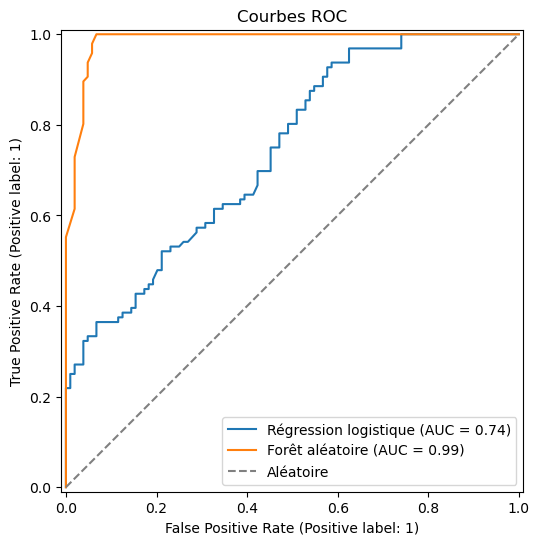

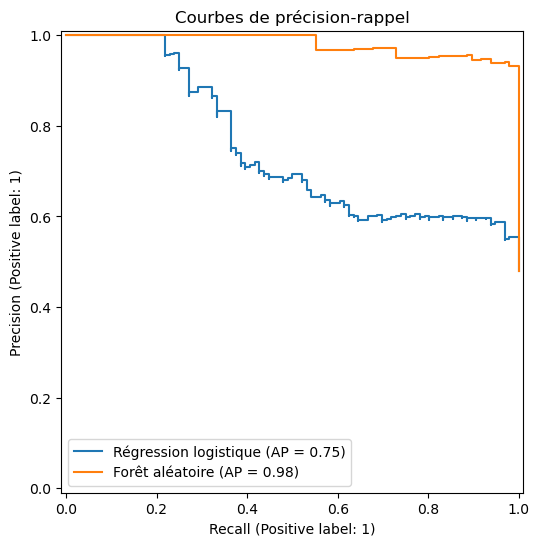

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.widgets import Button
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class Fanorona:
    def __init__(self):
        self.current_player = "Blancs"
        self.board = [[None for _ in range(3)] for _ in range(3)]
        self.pieces_placed = {"Blancs": 0, "Noir": 0}
        self.selected_piece = None

        # Initialiser matplotlib
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.ax.set_facecolor("#F5DEB3")  # Fond couleur bois
        self.ax.set_xlim(0, 300)
        self.ax.set_ylim(0, 300)
        self.ax.set_aspect('equal')
        self.ax.axis('off')  # Cacher les axes

        # Dessiner le plateau
        self.draw_board()

        # Gérer les clics sur le plateau
        self.fig.canvas.mpl_connect('button_press_event', self.handle_click)

        # Bouton de réinitialisation
        ax_reset = plt.axes([0.4, 0.05, 0.2, 0.075])  # Position du bouton
        self.reset_button = Button(ax_reset, 'Rejouer', color="#8B4513", hovercolor="#A0522D")
        self.reset_button.on_clicked(self.reset_game)

        # Afficher le tour actuel
        self.info_label = self.ax.text(150, 320, f"Tour des : {self.current_player}", 
                                       fontsize=14, ha='center', va='center', color="black")

        plt.show()

    def draw_board(self):
        # Dessiner les lignes du plateau
        for i in range(3):
            self.ax.plot([50, 250], [50 + i * 100, 50 + i * 100], color="brown", linewidth=2)  # Horizontales
            self.ax.plot([50 + i * 100, 50 + i * 100], [50, 250], color="brown", linewidth=2)  # Verticales
        self.ax.plot([50, 250], [50, 250], color="brown", linewidth=2)  # Diagonale principale
        self.ax.plot([250, 50], [50, 250], color="brown", linewidth=2)  # Diagonale secondaire

        # Dessiner les intersections
        self.intersections = []
        for row in range(3):
            for col in range(3):
                x, y = 50 + col * 100, 50 + row * 100
                self.intersections.append((x, y))
                self.ax.add_patch(Circle((x, y), 10, color="brown"))  # Taille ajustée

    def handle_click(self, event):
        if event.inaxes != self.ax:
            return  # Ignorer les clics en dehors du plateau

        x, y = event.xdata, event.ydata

        # Trouver l'intersection la plus proche
        for idx, (ix, iy) in enumerate(self.intersections):
            if abs(x - ix) <= 20 and abs(y - iy) <= 20:
                row, col = divmod(idx, 3)
                if self.board[row][col] == self.current_player:
                    self.select_piece(row, col)
                elif self.selected_piece:
                    self.move_piece(row, col, ix, iy)
                elif self.board[row][col] is None and self.pieces_placed[self.current_player] < 3:
                    self.place_piece(row, col, ix, iy)
                break

    def place_piece(self, row, col, x, y):
        # Placer le pion
        color = "white" if self.current_player == "Blancs" else "black"
        self.ax.add_patch(Circle((x, y), 15, color=color))
        self.board[row][col] = self.current_player
        self.pieces_placed[self.current_player] += 1

        if self.check_winner(row, col):
            print(f"FIN DE PARTIE: Les {self.current_player} gagnent !")
            self.reset_game()
            return

        # Changer de joueur
        self.current_player = "Noir" if self.current_player == "Blancs" else "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

    def select_piece(self, row, col):
        # Réinitialiser la bordure de l'ancien pion sélectionné
        if self.selected_piece:
            prev_row, prev_col = self.selected_piece
            for patch in self.ax.patches:
                if isinstance(patch, Circle) and patch.get_center() == (50 + prev_col * 100, 50 + prev_row * 100):
                    patch.set_edgecolor("black")
                    patch.set_linewidth(1)

        # Sélectionner le nouveau pion
        self.selected_piece = (row, col)
        for patch in self.ax.patches:
            if isinstance(patch, Circle) and patch.get_center() == (50 + col * 100, 50 + row * 100):
                patch.set_edgecolor("red")
                patch.set_linewidth(2)
                break

        self.info_label.set_text(f"{self.current_player}: Déplacez vers une case vide")
        self.fig.canvas.draw()

    def move_piece(self, row, col, x, y):
        if self.board[row][col] is not None:
            print("Mouvement impossible: La case est déjà occupée!")
            return

        prev_row, prev_col = self.selected_piece

        if not self.is_valid_move(prev_row, prev_col, row, col):
            print("Mouvement impossible: Essayez autre chose")
            return

        # Déplacer le pion
        self.board[prev_row][prev_col] = None
        self.board[row][col] = self.current_player

        # Effacer l'ancienne position
        for patch in self.ax.patches:
            if isinstance(patch, Circle) and patch.get_center() == (50 + prev_col * 100, 50 + prev_row * 100):
                patch.remove()
                break

        # Dessiner la nouvelle position
        color = "white" if self.current_player == "Blancs" else "black"
        self.ax.add_patch(Circle((x, y), 15, color=color))

        self.selected_piece = None

        if self.check_winner(row, col):
            print(f"FIN DE PARTIE: Les {self.current_player} gagnent !")
            self.reset_game()
            return

        # Changer de joueur
        self.current_player = "Noir" if self.current_player == "Blancs" else "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

    def is_valid_move(self, prev_row, prev_col, new_row, new_col):
        # Définir les déplacements valides en suivant les lignes du plateau
        valid_moves = {
            (0, 0): [(0, 1), (1, 0), (1, 1)],
            (0, 1): [(0, 0), (0, 2), (1, 1)],
            (0, 2): [(0, 1), (1, 1), (1, 2)],
            (1, 0): [(0, 0), (1, 1), (2, 0)],
            (1, 1): [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2)],
            (1, 2): [(0, 2), (1, 1), (2, 2)],
            (2, 0): [(1, 0), (1, 1), (2, 1)],
            (2, 1): [(2, 0), (1, 1), (2, 2)],
            (2, 2): [(1, 1), (1, 2), (2, 1)]
        }

        return (new_row, new_col) in valid_moves.get((prev_row, prev_col), [])

    def check_winner(self, row, col):
        # Vérifier les lignes, colonnes et diagonales pour une victoire
        # Ligne
        if all(self.board[row][c] == self.current_player for c in range(3)):
            return True
        # Colonne
        if all(self.board[r][col] == self.current_player for r in range(3)):
            return True
        # Diagonales
        if row == col and all(self.board[i][i] == self.current_player for i in range(3)):
            return True
        if row + col == 2 and all(self.board[i][2 - i] == self.current_player for i in range(3)):
            return True

        return False

    def reset_game(self, event=None):
        self.board = [[None for _ in range(3)] for _ in range(3)]
        self.pieces_placed = {"Blancs": 0, "Noir": 0}
        self.selected_piece = None
        self.ax.clear()
        self.draw_board()
        self.current_player = "Blancs"
        self.info_label.set_text(f"Tour des : {self.current_player}")
        self.fig.canvas.draw()

# Génération des données et entraînement des modèles (identique à avant)
def generate_data(self, num_games=1000):
        winning_configs = []
        losing_configs = []

        for _ in range(num_games):
            self.reset_game()
            winner = self.simulate_game()

            if winner == "Blancs":
                winning_configs.append([row[:] for row in self.board])
            elif winner == "Noir":
                losing_configs.append([row[:] for row in self.board])

            if len(winning_configs) >= 500 and len(losing_configs) >= 500:
                break

        return winning_configs, losing_configs
    
# winning_configs, losing_configs = Fanorona().generate_data()
# X, y = prepare_data(winning_configs, losing_configs)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

print(f"Accuracy de la régression logistique: {accuracy_score(y_test, y_pred_logistic)}")
print(f"Accuracy de la forêt aléatoire: {accuracy_score(y_test, y_pred_rf)}")

print("Rapport de classification pour la régression logistique:")
print(classification_report(y_test, y_pred_logistic))

print("Matrice de confusion pour la régression logistique:")
print(confusion_matrix(y_test, y_pred_logistic))

print("Rapport de classification pour la forêt aléatoire:")
print(classification_report(y_test, y_pred_rf))

print("Matrice de confusion pour la forêt aléatoire:")
print(confusion_matrix(y_test, y_pred_rf))


import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Affichage des matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matrice de confusion pour la régression logistique
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistic, ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Matrice de confusion (Régression logistique)")

# Matrice de confusion pour la forêt aléatoire
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("Matrice de confusion (Forêt aléatoire)")

plt.tight_layout()
plt.show()

# Affichage des courbes ROC
fig, ax = plt.subplots(figsize=(8, 6))

# Courbe ROC pour la régression logistique
RocCurveDisplay.from_estimator(logistic_model, X_test, y_test, ax=ax, name="Régression logistique")

# Courbe ROC pour la forêt aléatoire
RocCurveDisplay.from_estimator(random_forest_model, X_test, y_test, ax=ax, name="Forêt aléatoire")

ax.set_title("Courbes ROC")
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Aléatoire")
ax.legend()
plt.show()

# Affichage des courbes de précision-rappel
fig, ax = plt.subplots(figsize=(8, 6))

# Courbe de précision-rappel pour la régression logistique
PrecisionRecallDisplay.from_estimator(logistic_model, X_test, y_test, ax=ax, name="Régression logistique")

# Courbe de précision-rappel pour la forêt aléatoire
PrecisionRecallDisplay.from_estimator(random_forest_model, X_test, y_test, ax=ax, name="Forêt aléatoire")

ax.set_title("Courbes de précision-rappel")
ax.legend()
plt.show()